# Fixed Length Jingju Stytle Music Generation Using Feedforward VAE.

Input: Fixed Length of Pianoroll representation of a sample.

Aim: To generate the same length of jingju style music like the training sample.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
!cd "/content/drive/My Drive/CMC_final_project"

Mounted at /content/drive/


In [ ]:
!apt install musescore fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [3]:
pip install torch muspy numpy pypianoroll fluidsynth midi2audio

     |████████████████████████████████| 107 kB 23.6 MB/s 
     |████████████████████████████████| 5.6 MB 35.8 MB/s 
     |████████████████████████████████| 51 kB 6.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=b85298861fafb6f1de9d70f5d2394576065de653e5006c2bfd17ea7592847b40
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4513 sha256=3a19eb678c05a088022a5fbba80f912cd3c45ac220834fb8c3496bdbb98ff286
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built pretty-midi fluidsynth


In [4]:
# Colab cannot play music directly from music21 - must convert to .wav first
def play_wav(out_midi):
    out_wav = out_midi.replace('.mid','.wav')
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)


In [85]:
import muspy
import os
import torch
import numpy as np
import pypianoroll
from pypianoroll import Multitrack, Track
from pretty_midi import PrettyMIDI
from midi2audio import FluidSynth
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()
jingju_path = 'drive/My Drive/CMC_final_project/data/Jingju Scores Dataset/MusicXML/'



When reading a MIDI file, music.resolution is set to the pulses per quarter note (a.k.a., PPQ, PPQN, ticks per beat). When reading a MusicXML file, music.resolution is set to the division attribute, which determines the number of divisions per quarter note. When multiple division attributes are found, music.resolution is set to the least common multiple of them.
https://salu133445.github.io/muspy/timing.html

In [9]:
muspy.download_bravura_font()
muspy.download_musescore_soundfont()

Start downloading Bravura font.
Bravura font has successfully been downloaded to : /root/.muspy/musescore-general.
Start downloading MuseScore General soundfont.
MuseScore General soundfont has successfully been downloaded to : /root/.muspy/musescore-general.


In [10]:
# Create a directory if not exists
sample_dir = 'samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


In [93]:
# User-defined parameters
lowest_pitch = 48 # C3
n_pitches = 24 # 3 octaves

In [101]:
from torch.functional import Tensor
# data preparation
# use beat_resolution to select notes
data = []
beat_resolution = 8 # number of time steps per beat

"For a first approach to the results, we grouped the banshi \
in three groups: yuanban and erliu, in 2/4 metre and \
medium tempo ranges; manban, sanyan, zhongsanyan and \
kuaisanyan, in 4/4 metre and slower tempo ranges than the \
previous group; and kuaiban and liushui, in 1/4 metre and \
faster tempo ranges than the first group. "
fixed_len = 16 * beat_resolution
# it is actually a length of 8 beat, the concept of measure does not fit jingju since the dataset contains different rhymic pattern 
for file in os.listdir(jingju_path):
  
  if file.split('.')[-1] not in ['xml','musicxml']:
    print(f"Neglecting {file}")
    continue
  song = muspy.read_musicxml(os.path.join(jingju_path,file))
  multitrack = muspy.to_pypianoroll(song)
  multitrack.binarize()
  
  multitrack.set_resolution(beat_resolution)
  
  pianoroll = multitrack.stack() >0 # return 3D array, boolean
  pianoroll = pianoroll[:,:,lowest_pitch:lowest_pitch + n_pitches]
  # stack mulitrack into one track
  pianoroll = np.any(pianoroll,axis=0)

  # fixed length slicing window, one beat at a time
  n_total_units = multitrack.get_max_length()//beat_resolution
  

  if n_total_units == 1:
    data.append(pianoroll[:fixed_len])
  else:
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in range(n_total_units - fixed_len +1):
        start = idx * beat_resolution
        end = start + fixed_len
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(0,1)) < 10).any():
          print("too few notes")
          continue
        data.append(pianoroll[start:end])
random.shuffle(data)
print(np.shape(data))
data = np.stack(data)


Neglecting .muspy.success
Neglecting _converted
(14894, 128, 24)


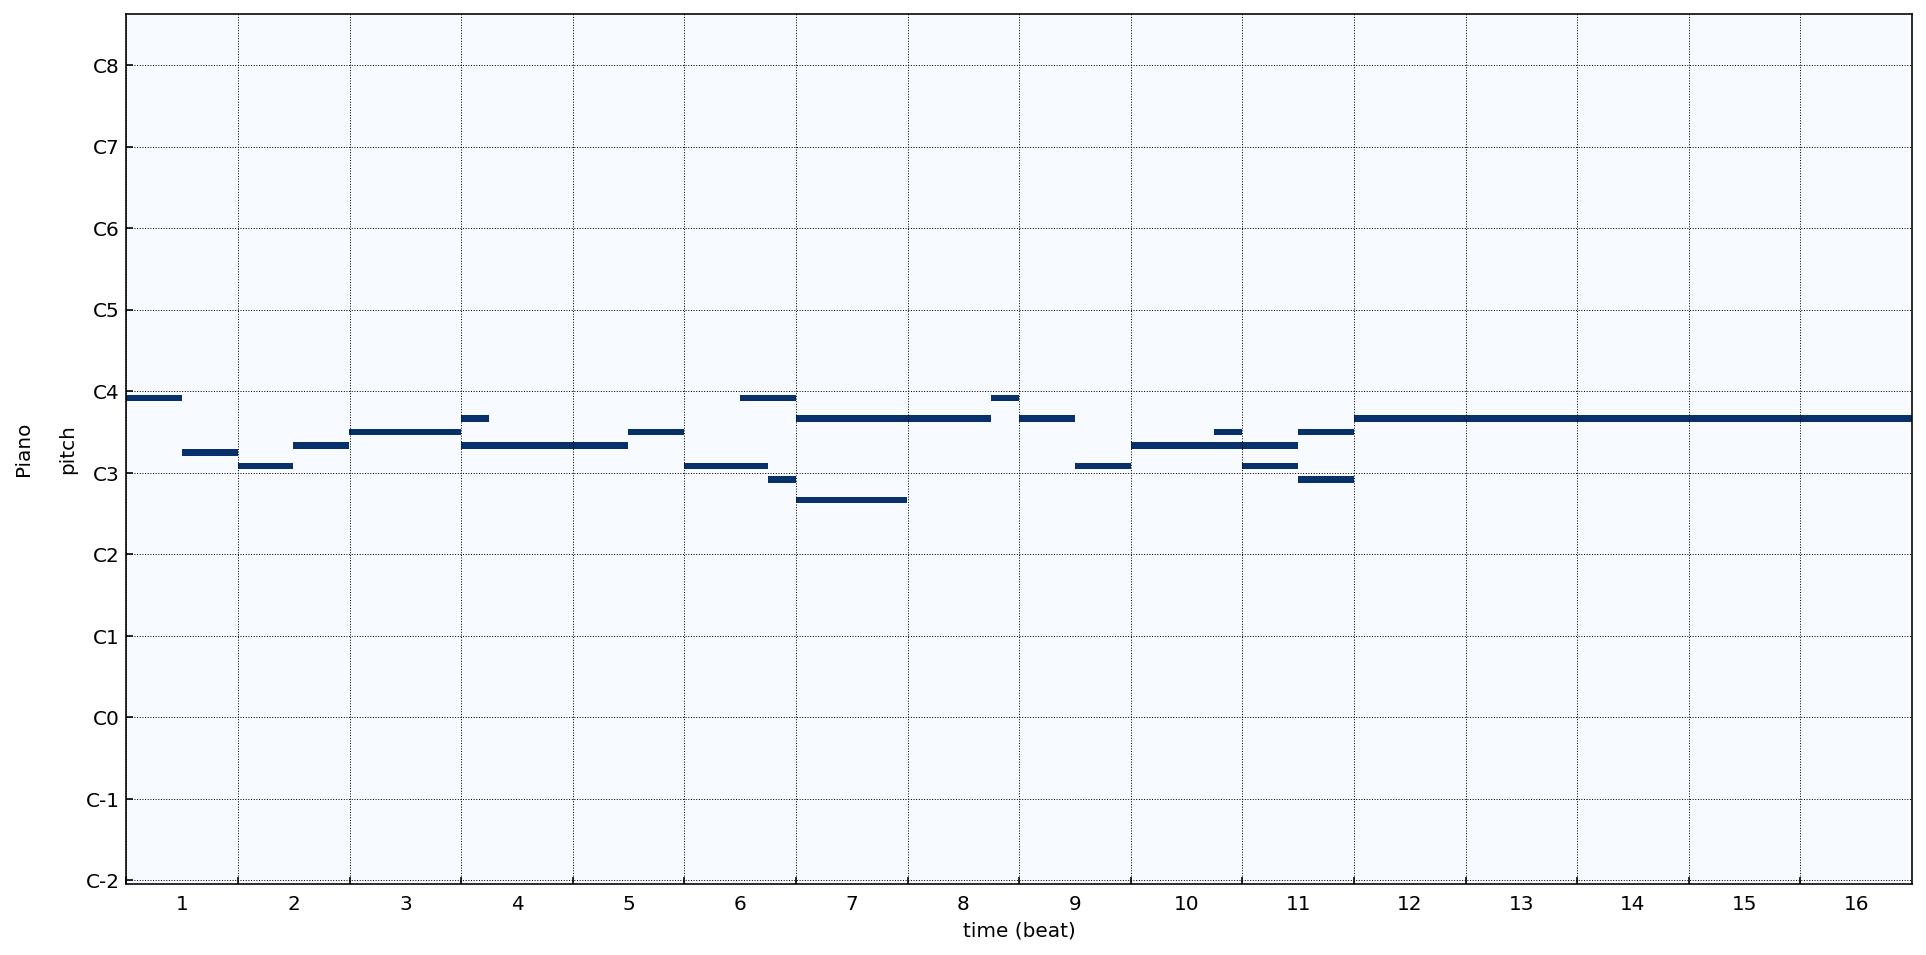

In [105]:
# visualize an example of training samples
# Write a midi file of a training sample

tracks = []
programs = 1  # program number for each track
is_drums = False  # drum indicator for each track
track_names = 'Piano'  # name of each track
tempo = 60

tempo_array = np.full((data.shape[1], 1), tempo)

random_idx = random.choice(range(0,(len(data))))
pianoroll = np.pad(np.concatenate(data[random_idx:random_idx + 1]), ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
tracks.append(Track(name=track_names, program=programs, is_drum=is_drums, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
train_sample = muspy.from_pypianoroll(multitrack)
for note in train_sample.tracks[0].notes:
  # note.duration = 1
  note.velocity = 64
train_midi_sample = 'samples/train_sample.mid'
muspy.write(train_midi_sample,train_sample)


axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
# for ax in axs:
#     for x in range(0, total_len*beat_resolution, beat_resolution):
#         if x % beat_resolution == 0:
#             ax.axvline(x - 0.5, color='k')
#         else:
#             ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [106]:
play_wav(train_midi_sample)

In [107]:
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)

In [108]:
#TODO: MODEL DESIGN; ONLY CONSIDER MELODY

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters

h1_dim = 1500
h2_dim = 1000
h3_dim = 400

z_dim = 64

batch_size = 128
learning_rate = 1e-3

input_size = n_pitches * fixed_len # 2*64*32=4096

# Data loader
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

# VAE model
class VAE(nn.Module):
  def __init__(self, input_size=input_size, h1_dim=1500, h2_dim=1000, h3_dim=400, z_dim=64):

    super(VAE, self).__init__()
    self.fc1 = nn.Linear(input_size, h1_dim)
    self.fc2 = nn.Linear(h1_dim, h2_dim)
    self.fc3 = nn.Linear(h2_dim, h3_dim)
    self.fc4 = nn.Linear(h3_dim, z_dim)
    self.fc5 = nn.Linear(h3_dim, z_dim)
    self.fc6 = nn.Linear(z_dim, h3_dim)
    self.fc7 = nn.Linear(h3_dim, h2_dim)
    self.fc8 = nn.Linear(h2_dim, h1_dim)
    self.fc9 = nn.Linear(h1_dim, input_size)
      
      
  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    h3 = F.relu(self.fc3(h2))
    return self.fc4(h3), self.fc5(h3)
  
  def reparameterize(self, mu, log_var):
    std = torch.exp(log_var/2)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc6(z))
    h2 = F.relu(self.fc7(h3))
    h1 = F.relu(self.fc8(h2))
    return F.sigmoid(self.fc9(h1))
  
  def forward(self, x):
      
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    x_reconst = self.decode(z)
    return x_reconst, mu, log_var

  def loss_function(self, recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD
  def train_loop(self, optimizer, train_loader, epoch, num_epoch, writer,log_interval=10):
    self.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
      optimizer.zero_grad()
      data = data[0].to(device).view(-1, input_size)
      x_reconst, mu, log_var = self.forward(data)
      BCE, KLD = self.loss_function(x_reconst, data, mu, log_var)
      loss = BCE + KLD
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
      if (batch_idx+1) % log_interval == 0:
        print(f'Train Epoch: [{epoch+1}/{num_epoch}],[{batch_idx+1}/{len(train_loader)}]\tReconst_Loss: {BCE.item():.6f}\tKCL_loss: {KLD.item():.6f}')
    
    average_loss = train_loss / len(train_loader)
    print(f"====> Epoch: {epoch+1} Average loss: {average_loss:.4f}")
    writer.add_scalar("Average_Loss/train",average_loss,epoch)
    return average_loss


In [18]:

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Uncomment to load previous model
# checkpoint = torch.torch.load("drive/My Drive/CMC_final_project/model/best_model_500epoch_four_beat.pyt",map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 300

# Start training
for epoch in range(num_epochs):
  average_loss = model.train_loop(optimizer,data_loader,epoch,num_epochs,writer,log_interval=10)
  



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: [1/300],[10/116]	Reconst_Loss: 51773.472656	KCL_loss: 7.589989
Train Epoch: [1/300],[20/116]	Reconst_Loss: 53291.890625	KCL_loss: 5.271121
Train Epoch: [1/300],[30/116]	Reconst_Loss: 49233.261719	KCL_loss: 5.524167
Train Epoch: [1/300],[40/116]	Reconst_Loss: 49333.992188	KCL_loss: 5.838065
Train Epoch: [1/300],[50/116]	Reconst_Loss: 46277.652344	KCL_loss: 232.054367
Train Epoch: [1/300],[60/116]	Reconst_Loss: 46468.546875	KCL_loss: 317.428162
Train Epoch: [1/300],[70/116]	Reconst_Loss: 47268.269531	KCL_loss: 243.887573
Train Epoch: [1/300],[80/116]	Reconst_Loss: 44701.660156	KCL_loss: 240.367828
Train Epoch: [1/300],[90/116]	Reconst_Loss: 46838.531250	KCL_loss: 254.986588
Train Epoch: [1/300],[100/116]	Reconst_Loss: 46140.351562	KCL_loss: 277.926697
Train Epoch: [1/300],[110/116]	Reconst_Loss: 45352.664062	KCL_loss: 188.567108
====> Epoch: 1 Average loss: 54863.8043
Train Epoch: [2/300],[10/116]	Reconst_Loss: 45384.636719	KCL_loss: 320.279968
Train Epoch: [2/300],[20/116]	

In [273]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict()
},f"drive/My Drive/CMC_final_project/model/best_model_{epoch+1}epoch_four_beat.pyt")

In [56]:

with torch.no_grad():
  
  generate_len = int(int(input("Enter the length of music that you want to generate(Unit: beat):")) / 4)
  z = torch.randn(generate_len, z_dim).to(device)
  out = model.decode(z).reshape(z.shape[0],fixed_len,n_pitches)
  


    


Enter the length of music that you want to generate(Unit: beat):32


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [70]:
threshold = 0.1

# mask = out.ge(threshold)
# predictions = out * mask.int().float()
predictions = torch.ge(out,threshold)

# print(predictions)
# most_probable = torch.argmax(predictions.int(),dim=2)
# # print(most_probable)
# predictions = torch.nn.functional.one_hot(most_probable, n_pitches)
# # print(predictions)
# predictions = predictions.type(dtype=torch.float32)

out_cpu = predictions.to(torch.device("cpu")).numpy()
print(np.shape(out_cpu))

(8, 32, 36)


Enter the desired BPM(Recommend:60): 50


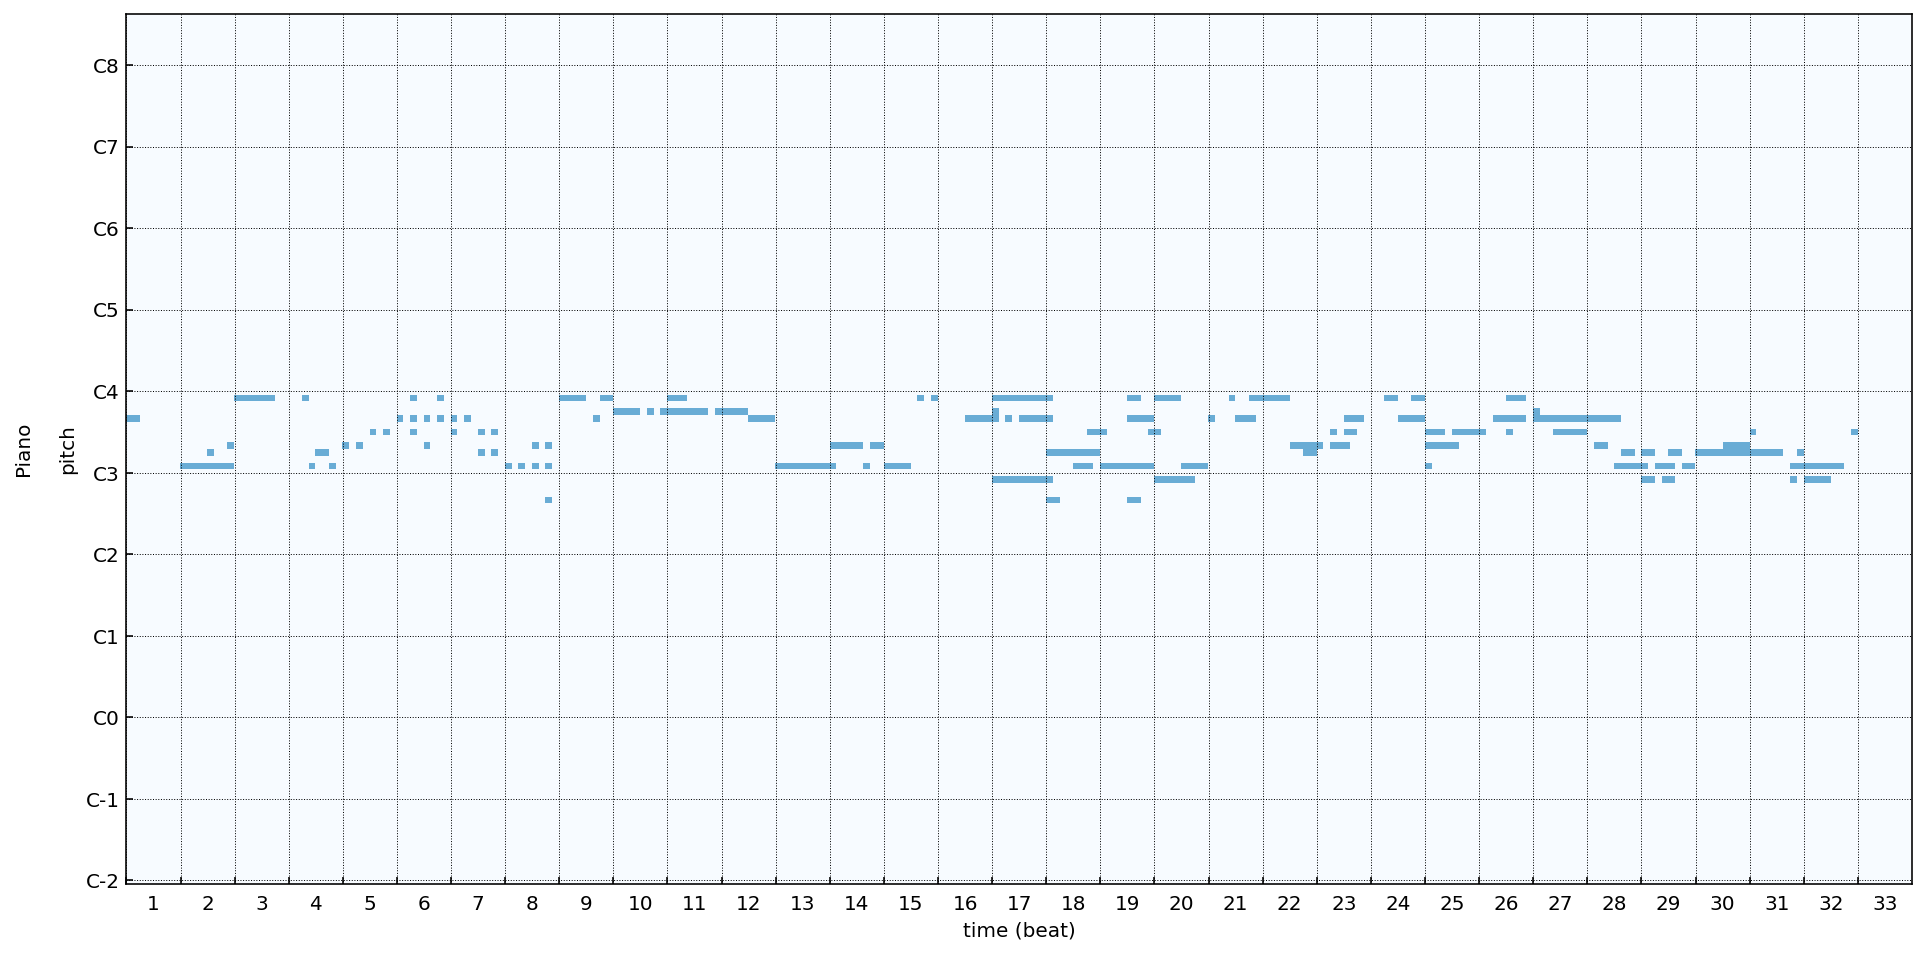

In [71]:
# visualize an example of a sample
# Show the source xml file name

tracks = []
programs = 1  # program number for each track
is_drums = False  # drum indicator for each track
track_names = 'Piano'  # name of each track
banshi_list = ['manban', 'zhongsanyan', 'yuanban', 'kuaisanyan', 'yaoban', '--', 'daoban', 'erliu', 'liushui', 'sanban', 'kuaiban', 'sanyan', 'kuai’erliu']
tempo = input("Enter the desired BPM(Recommend:60): ")
tempo_array = np.full((total_len, 1), tempo)

# the first dimension is batch

pianoroll = np.pad(np.concatenate(out_cpu), ((0,0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
tracks.append(Track(name=track_names, program=programs, is_drum=is_drums, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
output_sample = muspy.from_pypianoroll(multitrack)

# Post processing: 
for idx,note in enumerate(output_sample.tracks[0].notes):
  note.velocity = 64
  
  # Octave Error Elimination
  while note.pitch < 36:
    note.pitch = note.pitch +12
  # if idx+1 < len(output_sample.tracks[0].notes) and idx!=0:
  #   if note.pitch - output_sample.tracks[0].notes[idx-1].pitch ==-12 and (note.pitch - output_sample.tracks[0].notes[idx+1].pitch)==-12:
  #     print("Found")
  #     # output_sample.tracks[0].notes[idx-1].time = output_sample.tracks[0].notes[idx-1].time +note.time
  #     note.pitch = output_sample.tracks[0].notes[idx-1].pitch
  


multitrack = muspy.to_pypianoroll(output_sample)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))

plt.show()




In [72]:
# Demo: 
output_midi_file = 'samples/output_sample.mid'
muspy.write(output_midi_file,output_sample)
play_wav(output_midi_file)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_wav(train_midi_sample)

Output hidden; open in https://colab.research.google.com to view.